# Welcome to the SAGAN fit tutorial

We are lucky, WFIRST give us a preview event of its work. 
Let's have a look to your choice lightcurve first.

In [1]:
## First import the required libraries
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import time

lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels

First, let 's have a look to this event!

<IPython.core.display.Javascript object>


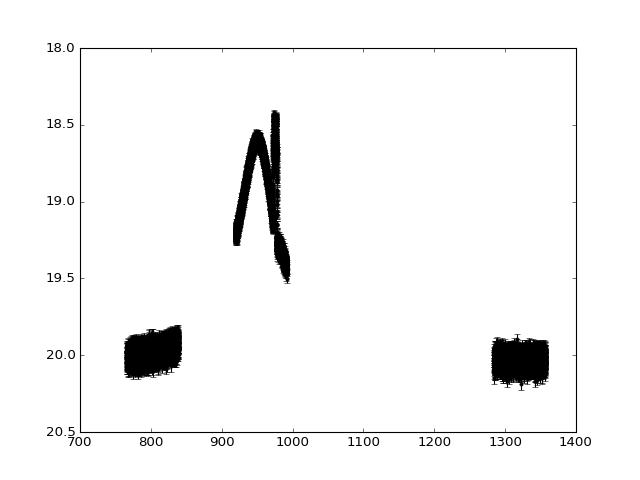

In [2]:
WFIRST_data = np.loadtxt('./WFIRST_binary_SAGAN.dat')[::1]

### Lets have a look on what it is exactly :
figure1 = plt.figure()
plt.errorbar(WFIRST_data[:,0]-2460000,WFIRST_data[:,1],yerr = WFIRST_data[:,2],fmt='.k')
plt.gca().invert_yaxis()
figure1.show()


Well, it looks similar to a point-source point lens model except around 7815 HJD. Let's try a PSPL fit then.
To do so, we need to define an event, then define a telescope and add it to the event class.


OK now we can fit this event with a PSPL model. And fit it with a Levenberg-Marquardt algorithm, given the good data quality.

In [3]:
### Create an event object. You can choose the name and RA,DEC in degrees :

your_event = event.Event()
your_event.name = 'WFIRST binary'
your_event.ra = 269.39166666666665 
your_event.dec = -29.22083333333333

###### Let's define the WFIRST observations

wfirst = telescopes.Telescope(name='WFIRST', camera_filter='W149', light_curve_magnitude=WFIRST_data)

your_event.telescopes.append(wfirst)



Start fit on WFIRST binary, with model PSPL and method LM
check_event  : Everything looks fine, this event can be fitted
initial_guess  : Initial parameters guess SUCCESS
lmarquardt  : Levenberg_marquardt fit SUCCESS
[2460950.539140518, 0.3560307708154202, 59.40694971716882, 1232.2203168649967, -0.2797461850059258, 217037.70447853953]


<IPython.core.display.Javascript object>


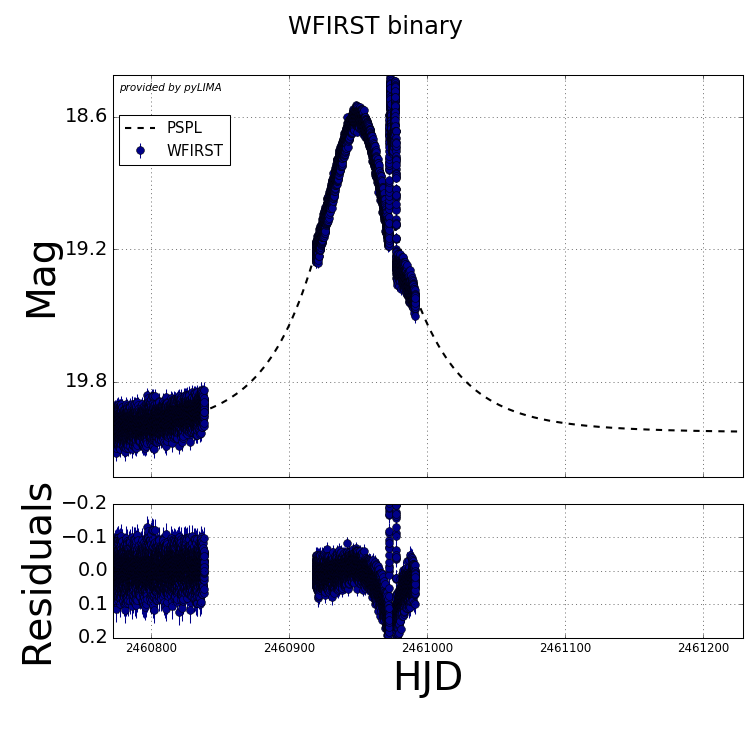

<IPython.core.display.Javascript object>


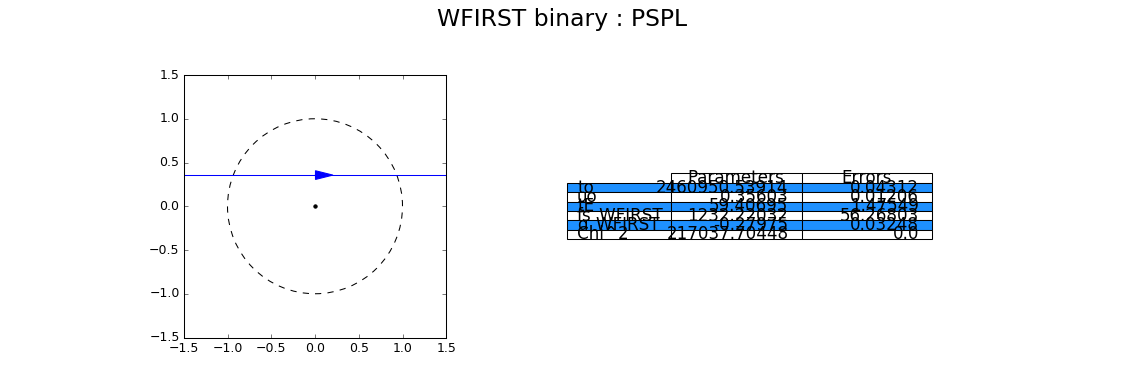

Chi2_LM : 217037.704479


In [4]:
### Construct the model.
pspl_model = microlmodels.create_model('PSPL', your_event)

### Fit your_event with model_1.
your_event.fit(pspl_model,'LM')
your_event.fits[0].produce_outputs()
print 'Chi2_LM :',your_event.fits[0].outputs.fit_parameters.chichi
#figure2 = plt.figure()
#figure2.show()



Hey, not to bad! Given the short duration of the anomaly and the good PSPL fit, this probably mean our anomaly is due to a planet. Then we can make some deduction. To do so, we have to define :

- delta_t = the duration of the anomaly
- delta_A = the amplitude of the anomaly 
- U(t_anomaly) = the impact parameter at the time  of anomaly

You can easily derive these properties by zooming around the anomaly!

In [5]:
#plt.close(figure2)
### First derive delta_t in days.
delta_t = 3

### Then derive delta_I, the amplitude of the anomaly in magnitude unit
delta_I =19.2-18.6

delta_A = 10**((delta_I)/2.5)

### Then the impact parameter at the anomaly time U(t_anomaly)
t_anomaly = 2460975.0

### Finally, extract PSPL parameters from first fit 
to = your_event.fits[0].outputs.fit_parameters.to
uo = your_event.fits[0].outputs.fit_parameters.uo
tE = your_event.fits[0].outputs.fit_parameters.tE

U_peak  = (uo**2+(t_anomaly-to)**2/tE**2)**0.5


All right! We can then derive some binary parameters using this :

- s = (U_peak +- (U_peak^2+4)^0.5)/2  This is accurate
- rho = delta_t/(2tE) This is NOT accurate
- q = delta_A/2*rho^2 This is NOT accurate

- x_caustic = s - 1/s
- y_caustic_close = 2*q^0.5/(s*(1+s^2)^0.5)
- y_caustic_wide = 0
- gamma = arcsin(uo/U_peak) 
- beta = arcsin(y_caustic/x_caustic)
- alpha = pi/2 - gamma - beta This is accurate

In [6]:
### Let's have s, rho, q and alpha

###Major image deviation
s = np.abs((U_peak+(U_peak**2+4)**0.5)/2)
###Minor image deviation
#s = np.abs((U_peak-(U_peak**2+4)**0.5)/2)


q = (delta_t/(2*tE))**2

rho = delta_t/(2*tE)


x_caustic = s-1/s

if s<1 :
    
    y_caustic = 2*q**0.5/(s*(1+s**2)**0.5)
    
else : 
    
    y_caustic = 0
    
gamma = np.arccos(uo/U_peak)
beta = np.arcsin(y_caustic/x_caustic)

alpha = (np.pi/2-gamma-beta) 


# Geometrical consideration
if s<1 :
    
    if t_anomaly > to:
        
        alpha = np.pi-alpha
else :
    
    if t_anomaly > to:
        alpha = -alpha
        
    else :
        alpha = alpha-np.pi
        
print to
print uo
print tE
print rho
print s,np.log10(s)
print q, np.log10(q)
print alpha


2460950.53914
0.356030770815
59.4069497172
0.0252495710879
1.30854117475 0.116787392766
0.000637540840124 -3.1954919896
-0.712952400888


OK, enough work for you. We have enough guess to fit the event. To be sure, we gonna use a general solver using differential evolution. But thanks to our guess, we can reduce a lot the parameter space!

<IPython.core.display.Javascript object>


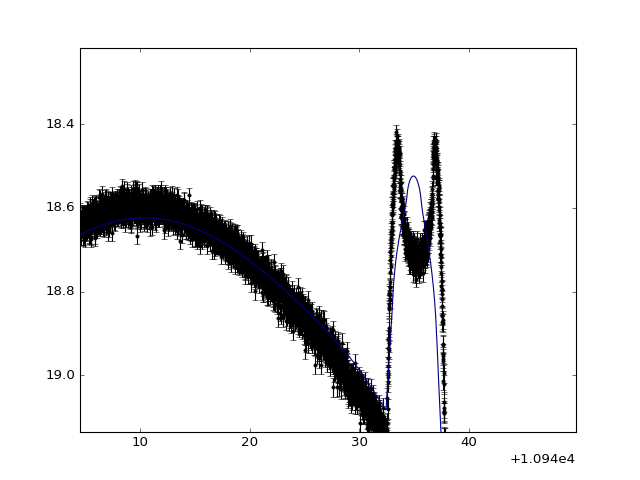

In [7]:
### Let's define a binary model


binary_model = microlmodels.create_model('USBL', your_event, model_arguments = [])




### Have a look to your guess 
binary_model.define_model_parameters()
estimate_parameters = [to, uo, tE, rho, np.log10(s), np.log10(q), alpha]

pyLIMA_parameters = binary_model.compute_pyLIMA_parameters(estimate_parameters)

model, wfirst_source_flux, wfirst_blend_flux = binary_model.compute_the_microlensing_model(wfirst, pyLIMA_parameters)
model_in_magnitude = 27.4-2.5*np.log10(model)
plt.figure()
plt.errorbar(WFIRST_data[:,0]-2450000,WFIRST_data[:,1],yerr = WFIRST_data[:,2],fmt='.k')
plt.gca().invert_yaxis()
plt.plot(wfirst.lightcurve_flux[:,0]-2450000, model_in_magnitude)
plt.show()


Start fit on WFIRST binary, with model USBL and method MCMC
check_event  : Everything looks fine, this event can be fitted
-36707.5562331
-41047.5135709
-38937.8673629
-36480.8507543
-39738.3119893
-36930.7228698
-29860.8172373
-34053.2955186
-18860.1035129
-51525.8443463
-38393.4060739
-49848.4037841
-51156.6153684
-40347.0418904
-40961.1154378
-42461.4089212
-60866.4321327
-38079.8021027
-30611.5112483
-41062.1698302
-38801.9672221
-39589.4364063
-39075.4237911
-60984.3631511
-37200.7017826
-73306.0787102
-48829.52752
-43453.4883719
-42791.3485642
-38634.8210384
-52783.0838519
-60145.2038352
-43236.9338958
-20683.8609655
-57651.3270434
-33838.6506425
-59757.4961155
-43558.4819246
-100608.283974
-44585.4019433
-141808.007839
-71490.7218536
-55830.9826781
-35871.0716548
-94893.0530511
-40520.7540764
-31680.1841028
-240980.587747
-62774.3275647
-39774.0667484
-136928.170258
-47623.6718189
-54435.4224183
-134417.727251
-88188.718223
-42475.0106929
-45347.3440908
-56744.499589
-33108.400

<IPython.core.display.Javascript object>


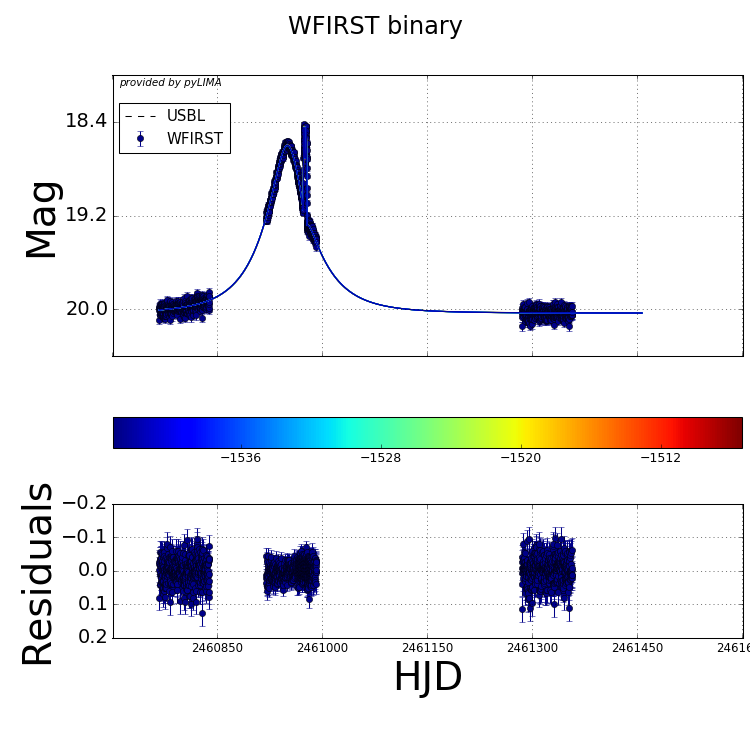

<IPython.core.display.Javascript object>


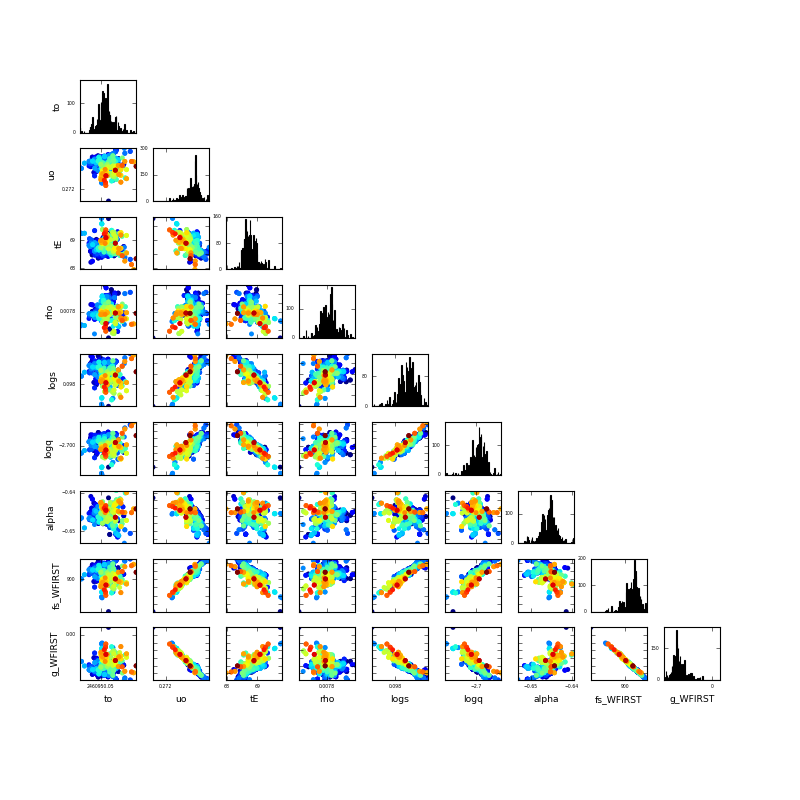

<IPython.core.display.Javascript object>


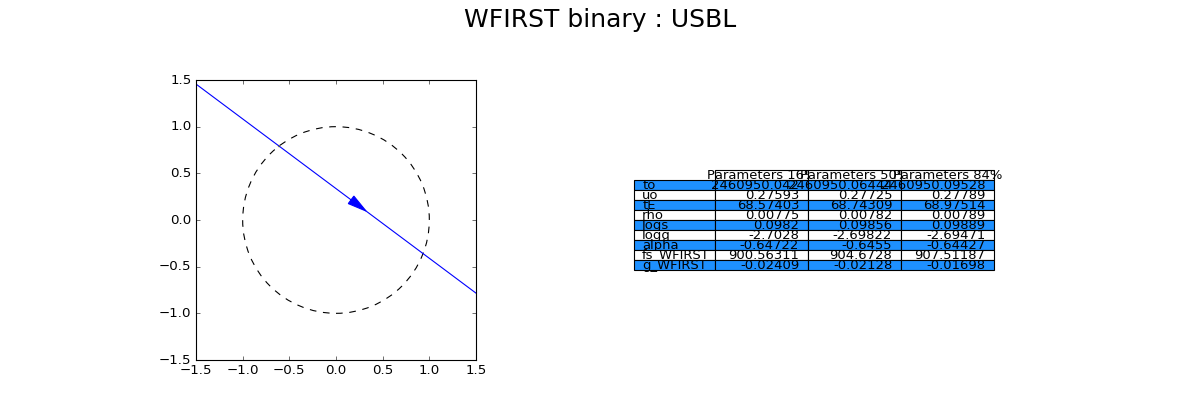

In [11]:
###### Speed up computations

your_event = event.Event()
your_event.name = 'WFIRST binary'
your_event.ra = 269.39166666666665 
your_event.dec = -29.22083333333333
binary_model.USBL_windows = [t_anomaly-10,t_anomaly+10]





start_anomaly = np.where(WFIRST_data[:,0]<binary_model.USBL_windows[0])[0][-1]
end_anomaly = np.where(WFIRST_data[:,0]>binary_model.USBL_windows[1])[0][0]


light_curve_reduce = np.r_[WFIRST_data[:start_anomaly:16],
                           WFIRST_data[start_anomaly:end_anomaly:5],
                           WFIRST_data[end_anomaly::16]]


#light_curve_reduce = WFIRST_data[::10]
wfirst = telescopes.Telescope(name='WFIRST', camera_filter='W149', light_curve_magnitude=light_curve_reduce)

your_event.telescopes.append(wfirst)

binary_model = microlmodels.create_model('USBL', your_event, model_arguments = [])


### to boundaries
#binary_model.parameters_boundaries[0] = [to-3,to+3]
### uo boundaries
#binary_model.parameters_boundaries[1] = [uo-0.1,uo+0.1]
### tE boundaries
#binary_model.parameters_boundaries[2] = [tE-5,tE+5]
### rho boundaries
#binary_model.parameters_boundaries[3] = [10**-4,10**-2]



### log_10(s) boundaries
#binary_model.parameters_boundaries[4] = [0.0,0.5]
### log_10(q) boundaries
#binary_model.parameters_boundaries[5] = [-4.0,-2.0]
### alpha boundaries
#binary_model.parameters_boundaries[6] = [-0.5,-1.0]

### DE_population_size scale the size of the DE population. More it is, bigger is your chance to find the minima
### but slower it is.
start = time.time()
binary_model.parameters_guess = estimate_parameters
binary_model.parameters_guess = [2460950.333, 0.271879 ,69.226, 0.007591, 0.09714, -2.70918 ,-0.64690]
#your_event.fit(binary_model, 'DE',  DE_population_size = 4)
your_event.fit(binary_model, 'MCMC',  flux_estimation_MCMC = 'polyfit')
print time.time()-start

#import pdb; pdb.set_trace()
your_event.fits[-1].produce_outputs()
plt.show()

Congrats for you binary fit!
